# 1 Loading Data

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

%matplotlib inline 

train_text_df = pd.read_csv('../datasets/training_text/training_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
print(train_text_df.shape)
submission_text_df = pd.read_csv('../datasets/test_text/test_text', sep='\|\|', engine='python', skiprows=1, names=['ID', 'Text'])
print(submission_text_df.shape)
train_text_column = train_text_df['Text']
submission_text_column = submission_text_df['Text']
# grouping all texts
text_column = np.append(train_text_column, submission_text_column)

# load features
training_features_df = pd.read_csv('../datasets/training_variants/training_variants', sep=',')
submission_features_df = pd.read_csv('../datasets/test_variants/test_variants', sep=',')

# load labels
training_labels = training_features_df['Class']
training_labels = pd.Series(np.array([i-1 for i in training_labels]), name='Class')

(3321, 2)
(5668, 2)


# 2 Data Cleaning

In [2]:
from nltk.corpus import stopwords
import nltk.data
import re

# English stop words
stops = set(stopwords.words("english"))
clean_text_column = []

# for debug, can handle corpus line by line
def get_text_lines_generator():
    for text in text_column:
        # Remove non-letters/digits
        text  = re.sub("[^a-zA-Z0-9]"," ", text)
        # Convert words to lower case
        words = text.lower().split()
        words = [w for w in words if not w in stops]
        yield ' '.join(words)
text_lines_generator = get_text_lines_generator()

for i in tqdm(range(len(text_column))):
    next_line = text_lines_generator.__next__()
    clean_text_column.append(next_line)

100%|█████████████████████████████████████████████████████████████████████████████| 8989/8989 [00:47<00:00, 189.33it/s]


# 3 Prepare Word Vectors

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

vectorizer = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), tokenizer=nltk.word_tokenize)

start = time()
text_tfid = vectorizer.fit_transform(clean_text_column)
print('tf-idf duration', time() - start, 'seconds')

tfid_svd = TruncatedSVD(n_components = 100, n_iter=30)
start = time()
truncated_text_tfid = tfid_svd.fit_transform(text_tfid)
print('TruncatedSVD duration', time() - start, 'seconds')

tf-idf duration 450.93435978889465 seconds
TruncatedSVD duration 1751.4304282665253 seconds


In [4]:
truncated_text_tfid_train = truncated_text_tfid[:train_text_df.shape[0]]
truncated_text_tfid_submission = truncated_text_tfid[train_text_df.shape[0]:]
print(truncated_text_tfid_train.shape)
print(truncated_text_tfid_submission.shape)

(3321, 100)
(5668, 100)


In [5]:
print('Raw:', text_column[0][:60])
print('Clean:', clean_text_column[0][:60])
print('tf-idf vector:', text_tfid[0].shape)
print('Truncated tf-idf vector:', truncated_text_tfid[0].shape)

Raw: Cyclin-dependent kinases (CDKs) regulate a variety of fundam
Clean: cyclin dependent kinases cdks regulate variety fundamental c
tf-idf vector: (1, 5371667)
Truncated tf-idf vector: (100,)


# 4 Encode gene & variation

## 4.1 tf-idf gene

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import nltk

# tf-idf gene
vectorizer = TfidfVectorizer(analyzer="char", 
                             ngram_range=(1, 10))

start = time()
tfidf_gene = vectorizer.fit_transform(training_features_df['Gene'].append(submission_features_df['Gene']))
print('tf-idf duration', time() - start, 'seconds')
print(tfidf_gene.shape)

svd = TruncatedSVD(n_components=50, n_iter=30)
start = time()
truncated_tfidf_gene = svd.fit_transform(tfidf_gene)
print('TruncatedSVD duration', time() - start, 'seconds')

print(truncated_tfidf_gene.shape)

# create data frame
encoded_training_gene_df = pd.DataFrame(columns=['gene'+str(i) for i in range(0, 50)])
encoded_submission_gene_df = pd.DataFrame(columns=['gene'+str(i) for i in range(0, 50)])

for i in tqdm(range(0, train_text_df.shape[0])):
    encoded_training_gene_df.loc[i] = truncated_tfidf_gene[i]

for i in tqdm(range(train_text_df.shape[0], truncated_tfidf_gene.shape[0])):
    encoded_submission_gene_df.loc[i] = truncated_tfidf_gene[i]
    
# set data type
encoded_training_gene_df = encoded_training_gene_df.astype(float)
encoded_submission_gene_df = encoded_submission_gene_df.astype(float)  

print(encoded_training_gene_df.shape)
print(encoded_submission_gene_df.shape)

tf-idf duration 0.19202613830566406 seconds
(8989, 8042)
TruncatedSVD duration 1.2133734226226807 seconds
(8989, 50)


100%|█████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:13<00:00, 430.90it/s]


(3321, 50)
(5668, 50)


## 4.2 tf-idf Variation

In [7]:
# tf-idf variations
vectorizer = TfidfVectorizer(analyzer="char", 
                             ngram_range=(1, 10))

start = time()
tfidf_variation = vectorizer.fit_transform(training_features_df['Variation'].append(submission_features_df['Variation']))
print('tf-idf duration', time() - start, 'seconds')
print(tfidf_variation.shape)

svd = TruncatedSVD(n_components=50, n_iter=30)


start = time()
truncated_tfidf_variation = svd.fit_transform(tfidf_variation)
print('TruncatedSVD duration', time() - start, 'seconds')

print(truncated_tfidf_variation.shape)

# create data frame
encoded_training_variation_df = pd.DataFrame(columns=['variation_'+str(i) for i in range(0, 50)])
encoded_submission_variation_df = pd.DataFrame(columns=['variation_'+str(i) for i in range(0, 50)])

for i in tqdm(range(0, train_text_df.shape[0])):
    encoded_training_variation_df.loc[i] = truncated_tfidf_variation[i]

for i in tqdm(range(train_text_df.shape[0], truncated_tfidf_variation.shape[0])):
    encoded_submission_variation_df.loc[i] = truncated_tfidf_variation[i]
    
# set data type
encoded_training_variation_df = encoded_training_variation_df.astype(float)
encoded_submission_variation_df = encoded_submission_variation_df.astype(float)  

print(encoded_training_variation_df.shape)
print(encoded_submission_variation_df.shape)

tf-idf duration 0.2852468490600586 seconds
(8989, 45001)
TruncatedSVD duration 3.827719211578369 seconds
(8989, 50)


100%|█████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:13<00:00, 430.49it/s]


(3321, 50)
(5668, 50)


In [8]:
# encoded_features = encoded_variation_df.join(one_hot_gene) 
encoded_training_features = encoded_training_variation_df.join(encoded_training_gene_df)
encoded_submission_features = encoded_submission_variation_df.join(encoded_submission_gene_df)
print(encoded_training_features.shape)
print(encoded_submission_features.shape)

(3321, 100)
(5668, 100)


# 5 Oversampling methods

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler 
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

tf_idf_X = np.array(encoded_training_features.join(pd.DataFrame(truncated_text_tfid_train)))
tf_idf_X_submit = np.array(encoded_submission_features.reset_index().join(pd.DataFrame(truncated_text_tfid_submission)).drop('index', 1))
print(tf_idf_X.shape)
print(tf_idf_X_submit.shape)


def quick_train_K_fold_CV(X, Y, folds=5, gen_submission=True, sub_file_prefix='tf_idf_lightgbm_fold'):
    # make sure class distribution
    folds = 5
    skf = StratifiedKFold(n_splits=folds, shuffle=True)

    skf_losses = []
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        tf_idf_clf = lgb.LGBMClassifier(
            n_estimators= 10000, # will be stopped by early_stopping_rounds
            objective = 'multiclass',
            num_class = 9,
            )
  
        tf_idf_clf.fit(X_train, y_train, 
                        verbose = False,
                        early_stopping_rounds = 300,
                        eval_set= [(X_train, y_train), (X_test, y_test)])
        y_pred = tf_idf_clf.predict_proba(X_test)
        test_log_loss = log_loss(y_test, y_pred)
        print(len(skf_losses), test_log_loss)
        skf_losses.append(test_log_loss)

        y_submit = tf_idf_clf.predict_proba(tf_idf_X_submit, num_iteration=tf_idf_clf.best_iteration)
        submit_df = pd.DataFrame(y_submit, columns=['class'+str(i+1) for i in range(0,9)])
        submit_df.head()
        submit_df.index.name='ID'
        submit_df.to_csv('../submissions/'+sub_file_prefix+str(len(skf_losses))+'_cv_loss_'+str(test_log_loss)+'.csv', sep=',')
    #     lgb.plot_metric(tf_idf_clf)
    print('avg. loss', np.mean(skf_losses))
    return tf_idf_clf

import seaborn as sn
def plot_confusion_matrix(clf):
    pred = clf.predict(tf_idf_X)
    cm = confusion_matrix(training_labels, pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm, index = [i+1 for i in range(0, 9)],
                      columns = [i+1 for i in range(0, 9)])
    plt.figure(figsize = (10,7))
    hmap = sn.heatmap(df_cm, annot=True)
    hmap.set_title('Confusion Matrix')
    hmap.set_xlabel('Predictions')
    hmap.set_ylabel('True labels')


(3321, 200)
(5668, 200)


In [10]:
clf = quick_train_K_fold_CV(tf_idf_X, training_labels, 5, False, 'tf_idf_lightgbm_fold')

0 0.982129812722
1 0.859355764372
2 0.888907602915
3 0.957501301579
4 0.913429944876
avg. loss 0.920264885293


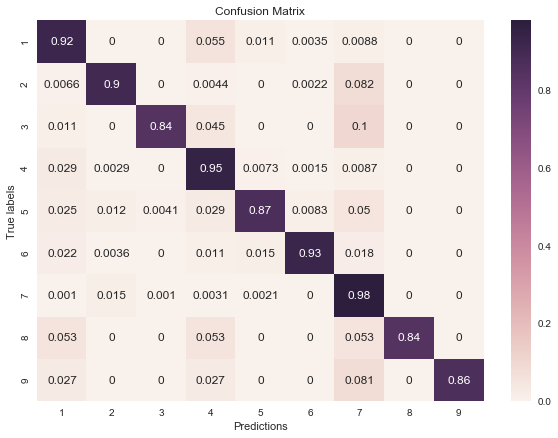

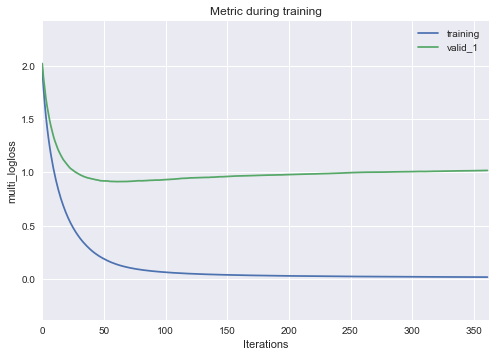

In [11]:
plot_confusion_matrix(clf)
lgb.plot_metric(clf)

## RandomOverSampler

In [12]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_random_resampled, y_random_resampled = ros.fit_sample(tf_idf_X, training_labels)
from collections import Counter
print(sorted(Counter(y_random_resampled).items()))

[(0, 953), (1, 953), (2, 953), (3, 953), (4, 953), (5, 953), (6, 953), (7, 953), (8, 953)]


In [13]:
clf_random_resampled = quick_train_K_fold_CV(X_random_resampled, y_random_resampled, 5, False, 'random_resmpled_tf_idf_lightgbm_fold')

0 0.190161004648
1 0.213050581252
2 0.199888520759
3 0.218608711107
4 0.221582178713
avg. loss 0.208658199296


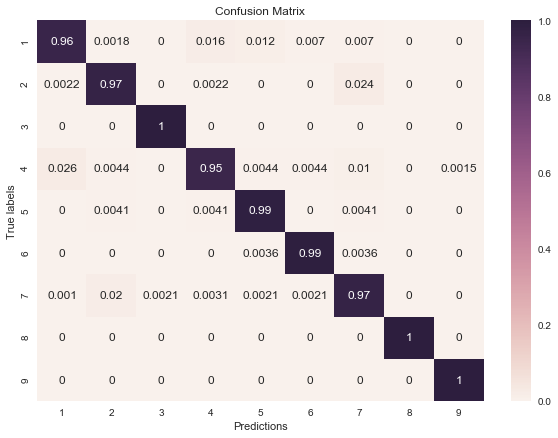

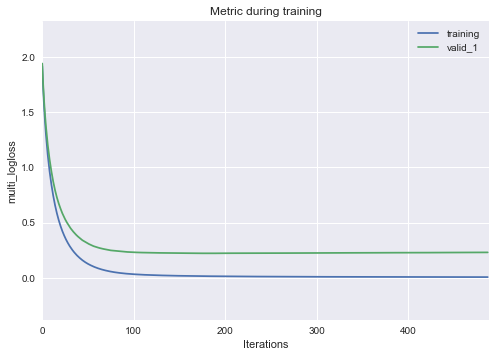

In [14]:
plot_confusion_matrix(clf_random_resampled)
lgb.plot_metric(clf_random_resampled)

In [15]:
# cv:
# 0 0.204229011188
# 1 0.22009743922
# 2 0.233257394705
# 3 0.253613935915
# 4 0.221920593516
# kaggle:
# 0.61230

## SMOTE 

In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote_resampled, y_smote_resampled = smote.fit_sample(tf_idf_X, training_labels)
from collections import Counter
print(sorted(Counter(y_smote_resampled).items()))

C:\Users\kingy\Anaconda3\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


[(0, 568), (1, 452), (2, 89), (3, 686), (4, 242), (5, 275), (6, 953), (7, 953), (8, 37)]


In [17]:
clf_smote_resampled = quick_train_K_fold_CV(X_smote_resampled, y_smote_resampled, 5, False, 'smote_resampled_tf_idf_lightgbm_fold')

0 0.710360652234
1 0.66779541764
2 0.672077715011
3 0.746836628643
4 0.74973007855
avg. loss 0.709360098416


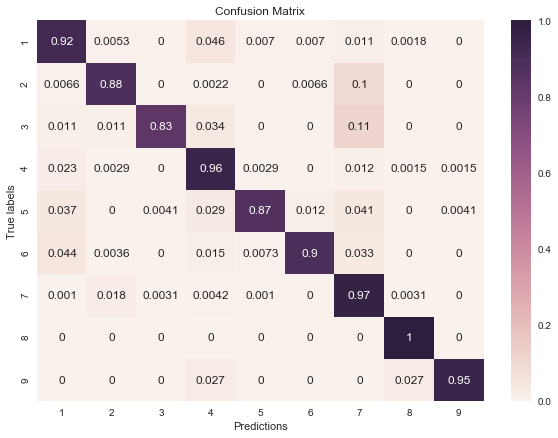

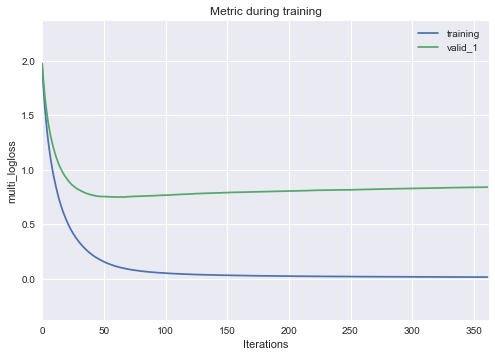

In [18]:
plot_confusion_matrix(clf_smote_resampled)
lgb.plot_metric(clf_smote_resampled)

## ADASYN

In [19]:
from imblearn.over_sampling import ADASYN
adasyn = ADASYN()
X_adasyn_resampled, y_adasyn_resampled = adasyn.fit_sample(tf_idf_X, training_labels)
from collections import Counter
print(sorted(Counter(y_adasyn_resampled).items()))

C:\Users\kingy\Anaconda3\lib\site-packages\imblearn\base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


[(0, 568), (1, 452), (2, 89), (3, 686), (4, 242), (5, 275), (6, 953), (7, 949), (8, 37)]


In [20]:
clf_adasyn_resampled = quick_train_K_fold_CV(X_adasyn_resampled, y_adasyn_resampled, 5, True, 'adasyn_resampled_tf_idf_lightgbm_fold')

0 0.766540245495
1 0.718281985374
2 0.735901463014
3 0.708109288304
4 0.64400076567
avg. loss 0.714566749571


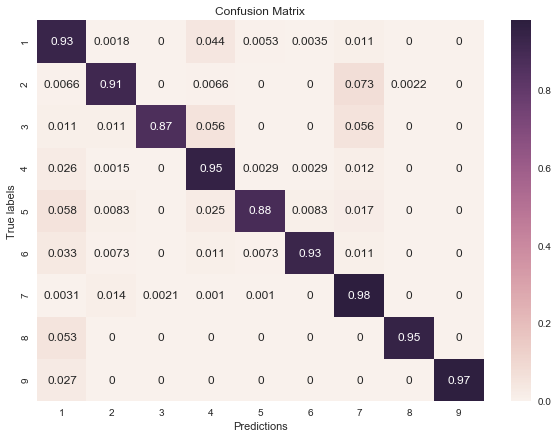

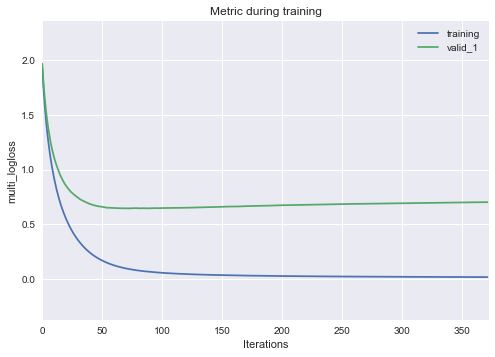

In [21]:
plot_confusion_matrix(clf_adasyn_resampled)
lgb.plot_metric(clf_adasyn_resampled)

# Tuning Model

In [22]:
def grid_search(X, Y, folds, max_depth, num_leaves, boosting_type):
    # make sure class distribution
    folds = 5
    skf = StratifiedKFold(n_splits=folds, shuffle=True)

    skf_losses = []
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        tf_idf_clf = lgb.LGBMClassifier(
            n_estimators= 10000, # will be stopped by early_stopping_rounds
            objective = 'multiclass',
            num_class = 9,
            max_depth = max_depth,
            num_leaves= num_leaves,
            boosting_type = boosting_type
            )
  
        tf_idf_clf.fit(X_train, y_train, 
                        verbose = False,
                        early_stopping_rounds = 300,
                        eval_set= [(X_train, y_train), (X_test, y_test)])
        y_pred = tf_idf_clf.predict_proba(X_test)
        test_log_loss = log_loss(y_test, y_pred)
        print(len(skf_losses), test_log_loss)
        skf_losses.append(test_log_loss)
    print('avg. loss', np.mean(skf_losses))
    return (tf_idf_clf, np.mean(skf_losses), (max_depth, num_leaves, boosting_type))

In [23]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_random_resampled, y_random_resampled = ros.fit_sample(tf_idf_X, training_labels)
from collections import Counter
print(sorted(Counter(y_random_resampled).items()))

[(0, 953), (1, 953), (2, 953), (3, 953), (4, 953), (5, 953), (6, 953), (7, 953), (8, 953)]


In [24]:
import itertools
max_depth_options = [4, 8, 12, 16, 20]
nun_leaves_options = [4, 8, 12, 16,  20]
boosting_options = ['gbdt', 'dart', 'goss']

best_clf = None
best_loss = 999
best_parms = None
for max_depth, num_leaves, boosting_type in (itertools.product(max_depth_options, nun_leaves_options, boosting_options)):
    print(max_depth, num_leaves, boosting_type)
    start = time()
    clf, avg_loss, parms = grid_search(X_random_resampled, y_random_resampled, 5, max_depth, num_leaves, boosting_type)
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_clf = clf
        best_parms = parms
    print('\t\t', start - time() ,'Current Best', best_parms, best_loss)

4 4 gbdt
0 0.232813522923
1 0.256036155097
2 0.203469921951
3 0.237093274052
4 0.218641924075
avg. loss 0.22961095962
		 -175.5537829399109 Current Best (4, 4, 'gbdt') 0.22961095962
4 4 dart
0 0.220362468234
1 0.226815198837
2 0.211242522631
3 0.219334741636
4 0.226638530884
avg. loss 0.220878692444
		 -5174.976654052734 Current Best (4, 4, 'dart') 0.220878692444
4 4 goss
0 0.236278033445
1 0.22581722563
2 0.215553372438
3 0.219528526208
4 0.231763697686
avg. loss 0.225788171081
		 -106.12901425361633 Current Best (4, 4, 'dart') 0.220878692444
4 8 gbdt
0 0.210304125291
1 0.206064688863
2 0.199675288076
3 0.207572355914
4 0.234751052459
avg. loss 0.211673502121
		 -122.36635041236877 Current Best (4, 8, 'gbdt') 0.211673502121
4 8 dart
0 0.212613282584
1 0.239121176624
2 0.238003202016
3 0.232213944815
4 0.178275815166
avg. loss 0.220045484241
		 -2030.6336238384247 Current Best (4, 8, 'gbdt') 0.211673502121
4 8 goss
0 0.215879716915
1 0.197952693794
2 0.199441558097
3 0.228983171185
4 0

In [25]:
print('Current Best', best_parms, best_loss)

Current Best (12, 20, 'gbdt') 0.196738930949


## Final Model

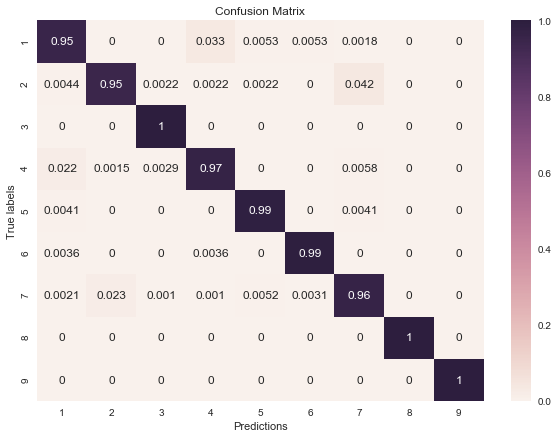

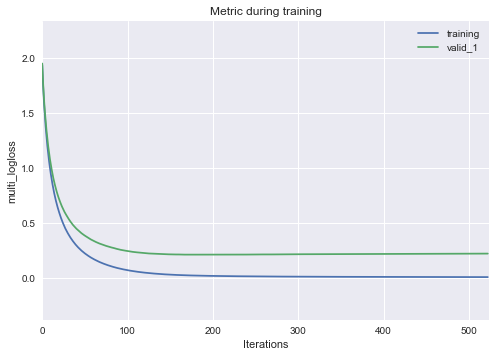

In [37]:
plot_confusion_matrix(best_clf)
lgb.plot_metric(best_clf)